# Exploring data augmentation methods

https://www.kaggle.com/code/coni57/model-from-arxiv-1805-00794#Model

### Import libaries

In [ ]:
# Common libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import torch
import os

import gc

from common_utils import set_and_get_seed, get_dataloader

# Seed
SEED = set_and_get_seed()

### Labels

In [2]:
labels = {
    0: "N",
    1: "S",
    2: "V",
    3: "F",
    4: "Q"
}

## Original Dataset

Column names are not provided in csv file, hence we will set header parameter to None below to obtain the the correct train and test datasets

In [3]:
train_data = pd.read_csv("Heartbeat_Dataset/mitbih_train.csv", header=None)
# test_data = pd.read_csv("Heartbeat_Dataset/mitbih_test.csv", header=None)

train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split train dataset into train and validation sets before performing data augmentation

In [4]:
from sklearn.model_selection import train_test_split

# Separate features and labels
X_train = train_data.iloc[:, :-1].values  # Exclude label
y_train = train_data.iloc[:, -1].values   # Labels

# # Stratifying the split so both train and validation sets have same class distribution
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train)

### View data distribution

In [111]:
# Check number of samples in datasets
print(f"Number of samples in train data: {X_train.shape[0]}")

# Check distribution of classes in test and train sets
classes, counts = np.unique(y_train, return_counts=True)
class_labels = np.vectorize(labels.get)(classes) # convert to their string labels

# print the counts
print(np.asarray((class_labels, counts)).T)

Number of samples in train data: 70043
[['N' '57977']
 ['S' '1778']
 ['V' '4630']
 ['F' '513']
 ['Q' '5145']]


C:\Users\randa\AppData\Local\Temp\ipykernel_71104\832063077.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.barplot(x=class_labels, y=counts, palette=colors)
C:\Users\randa\AppData\Local\Temp\ipykernel_71104\832063077.py:4: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sb.barplot(x=class_labels, y=counts, palette=colors)


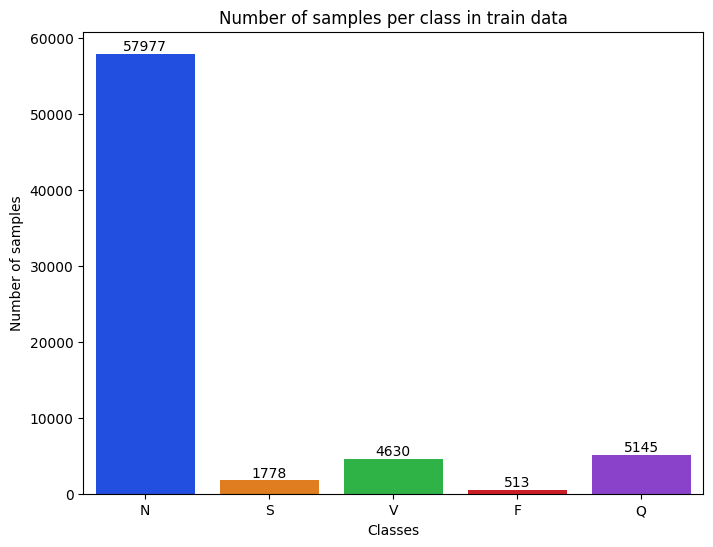

In [ ]:
colors = sb.color_palette('bright', 5)

plt.figure(figsize=(8, 6))
ax = sb.barplot(x=class_labels, y=counts, palette=colors)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of samples per class in train data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.show()

Text(0.5, 1.0, 'Percentage of each class in train data')

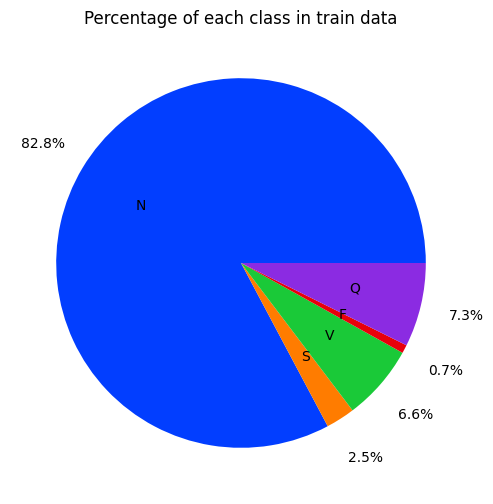

In [113]:
plt.figure(figsize=(8, 6))
plt.pie(x=counts, labels=class_labels, colors=colors,
        autopct='%1.1f%%', pctdistance=1.25, labeldistance=.6)
plt.title('Percentage of each class in train data')

As can be seen, the distribution of the data is very imbalanced with class N having significantly more data points compared to the other classes, this could result in training a biased model towards the majority class, N in this case. The models trained from the imbalanced data may not generalise well to new, unseen data especially for the minority classes.

## Synthetic Minority Over-Sampling Technique (SMOTE)

### Resample data using SMOTE

In [5]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [6]:
print(X_train_smote.shape)
print(y_train_smote.shape)

(362355, 187)
(362355,)


In [ ]:
combined_smote = np.concatenate((X_train_smote, y_train_smote.reshape(-1, 1)), axis=1)
combined_smote_df = pd.DataFrame(combined_smote)
combined_smote_df.to_csv('augmented_data/smote_dataset.csv')

# Free memory
del combined_smote
del combined_smote_df
gc.collect()

[['N' '72471']
 ['S' '72471']
 ['V' '72471']
 ['F' '72471']
 ['Q' '72471']]


Text(0.5, 1.0, 'Percentage of each class in resampled train data')

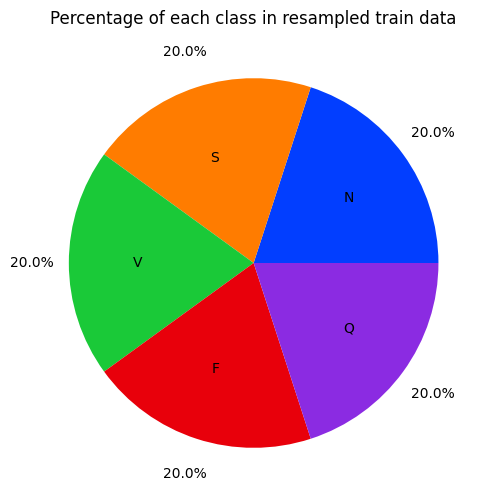

In [13]:
classes, counts = np.unique(y_train_smote, return_counts=True)
class_labels = np.vectorize(labels.get)(classes) # convert to their string labels

colors = sb.color_palette('bright', 5)

# print the counts
print(np.asarray((class_labels, counts)).T)

plt.figure(figsize=(8, 6))
plt.pie(x=counts, labels=class_labels, colors=colors,
        autopct='%1.1f%%', pctdistance=1.2, labeldistance=.6)
plt.title('Percentage of each class in resampled train data')

By using SMOTE, we sampled the minority classes (S, V, Q and F) and generated more data for them in order to match the number of samples in the majority class N, to get a balanced dataset where all classes have the same number of samples.

## Signal Transformation (Stretch and Amplify)

In [14]:
y_train

array([0., 0., 0., ..., 4., 4., 4.])

In [15]:
C0 = np.argwhere(y_train == 0).flatten()
C1 = np.argwhere(y_train == 1).flatten()
C2 = np.argwhere(y_train == 2).flatten()
C3 = np.argwhere(y_train == 3).flatten()
C4 = np.argwhere(y_train == 4).flatten()

In [30]:
print(C0.shape)
print(C1.shape)
print(C2.shape)
print(C3.shape)
print(C4.shape)

(72471,)
(2223,)
(5788,)
(641,)
(6431,)


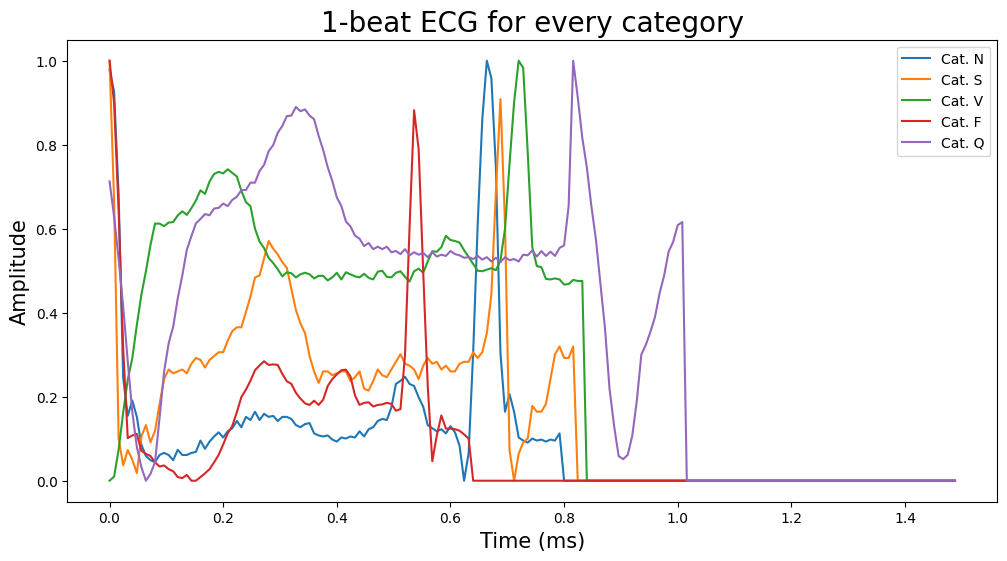

In [ ]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(12, 6))
plt.plot(x, X_train[C0, :][0], label="Cat. N")
plt.plot(x, X_train[C1, :][0], label="Cat. S")
plt.plot(x, X_train[C2, :][0], label="Cat. V")
plt.plot(x, X_train[C3, :][0], label="Cat. F")
plt.plot(x, X_train[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

# Free memory
del C0
del C1
del C2
del C3
del C4
gc.collect()

In [17]:
from scipy.signal import resample
import random

def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment_data(data):
    augmented_data = []
    for x in data:
        augmented_data.append(x)          # Original data
        augmented_data.append(stretch(x)) # Augmented with stretch
        augmented_data.append(amplify(x)) # Augmented with amplify
    return np.array(augmented_data)

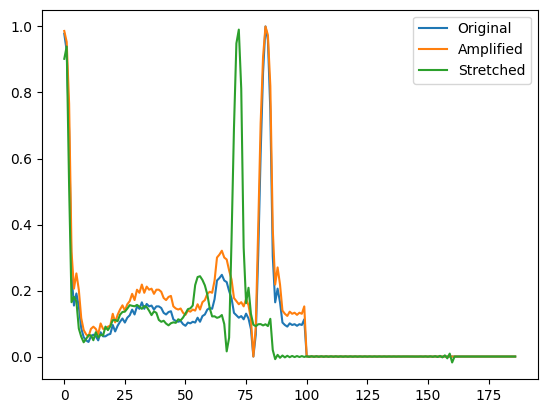

In [21]:
plt.plot(X_train[0, :], label='Original')
plt.plot(amplify(X_train[0, :]), label='Amplified')
plt.plot(stretch(X_train[0, :]), label='Stretched')
plt.legend(loc='upper right')
plt.show()

In [23]:
y_train_st = np.repeat(y_train, 3)
X_train_st = augment_data(X_train)

print(f'y_train_st: {y_train_st.shape}')
print(f'X_train_st: {X_train_st.shape}')

y_train_st: (262662,)
X_train_st: (262662, 187)


In [ ]:
combined_st = np.concatenate((X_train_st, y_train_st.reshape(-1, 1)), axis=1)
combined_st_df = pd.DataFrame(combined_st)
combined_st_df.to_csv('augmented_data/st_dataset.csv')

# Free memory
del combined_st
del combined_st_df
gc.collect()

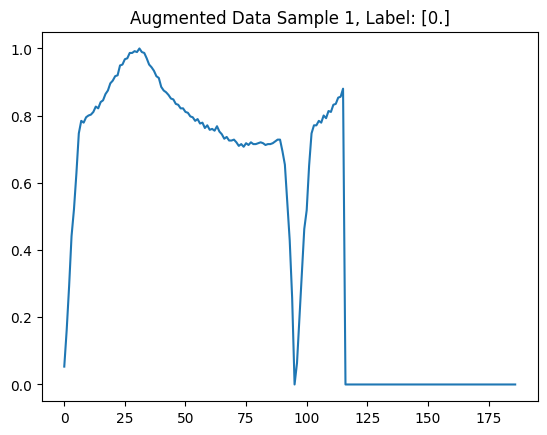

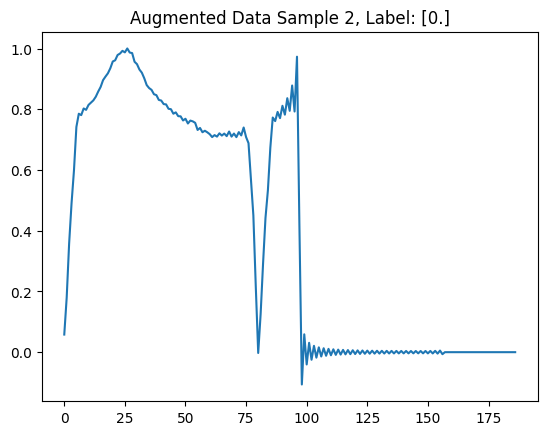

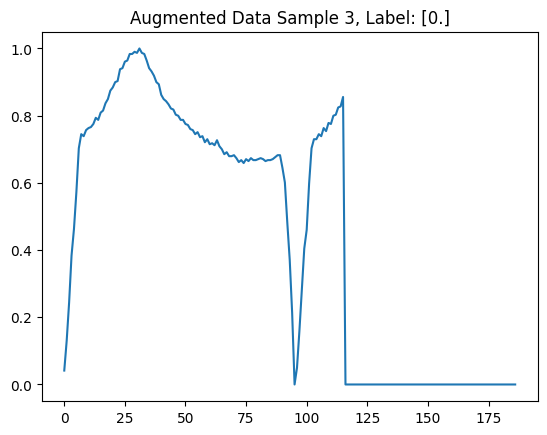

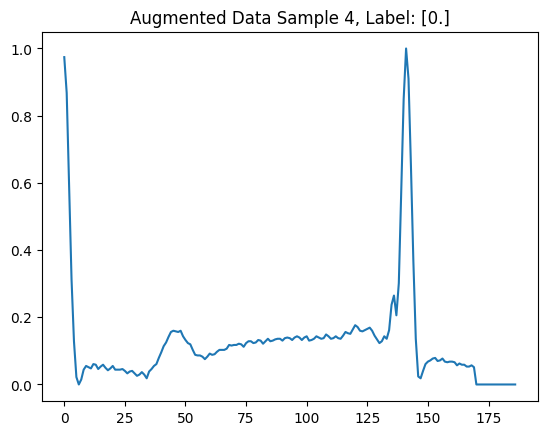

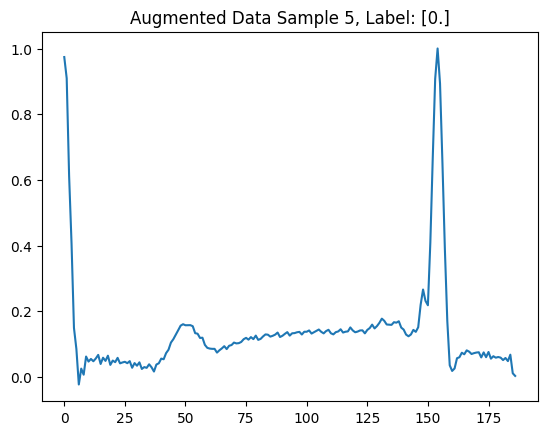

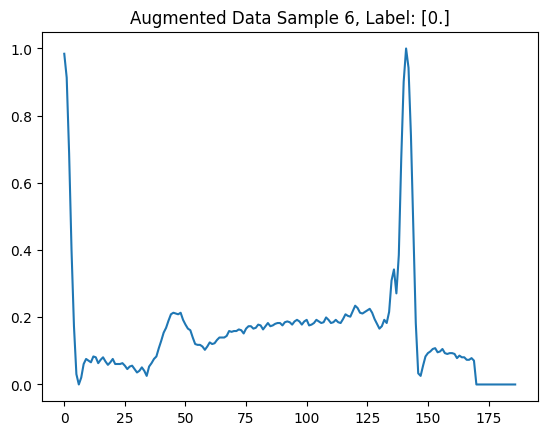

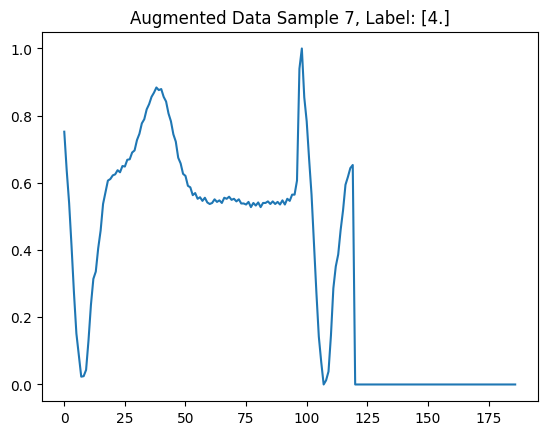

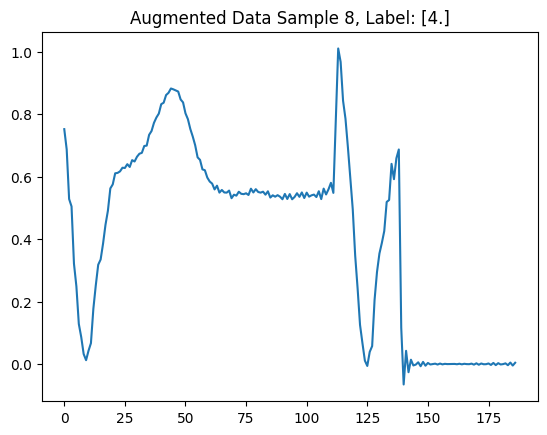

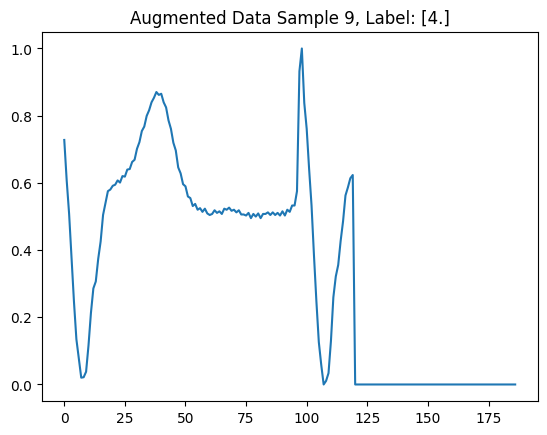

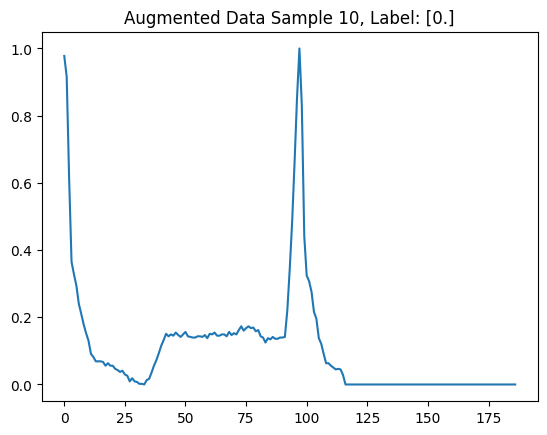

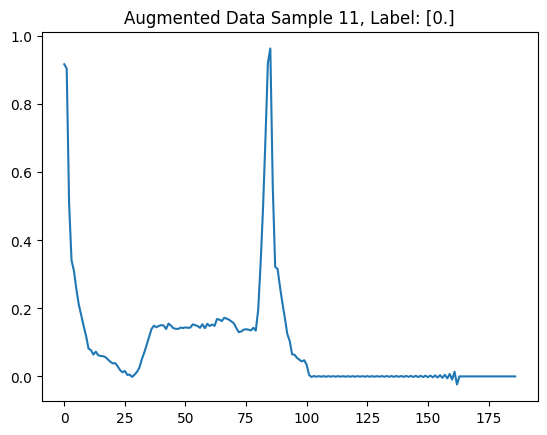

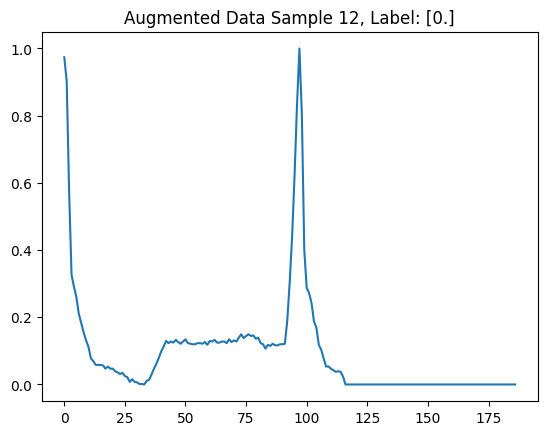

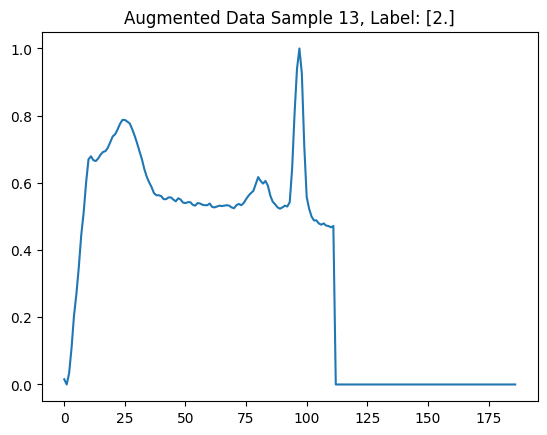

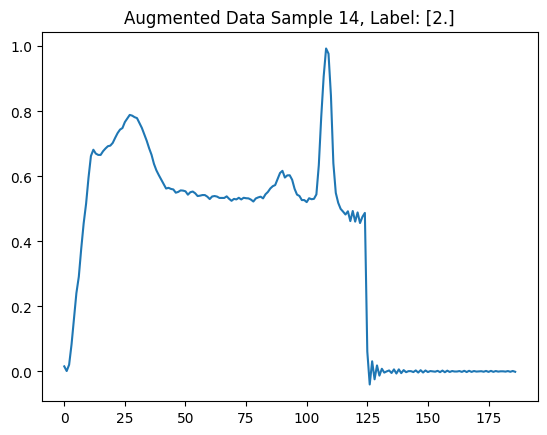

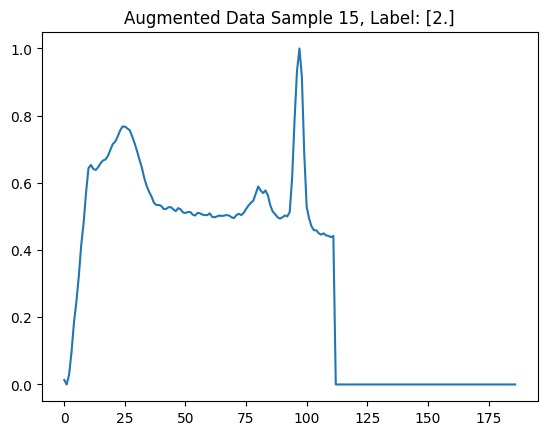

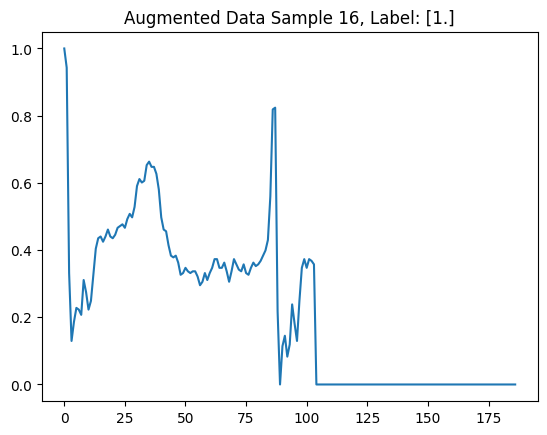

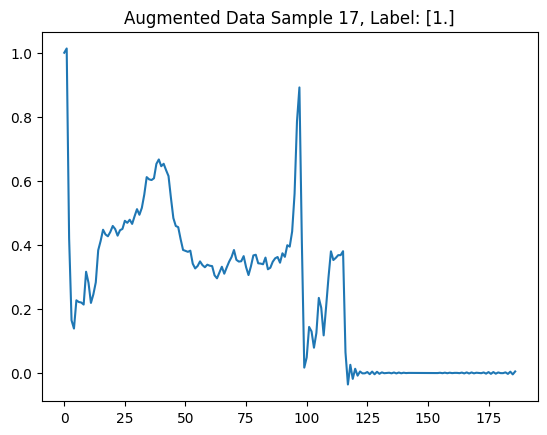

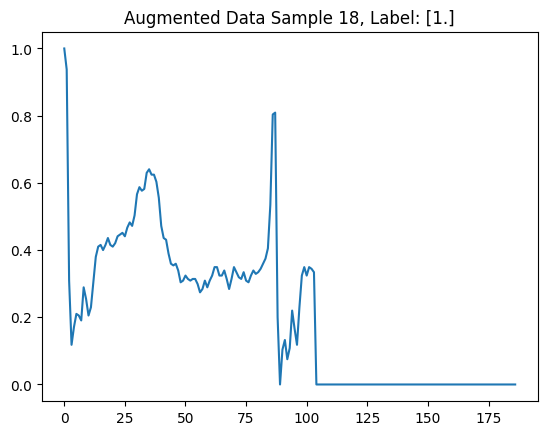

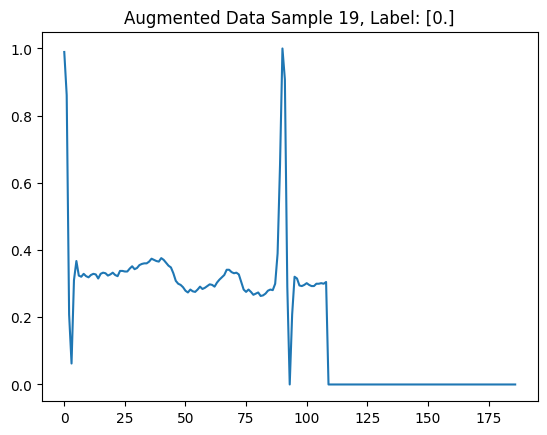

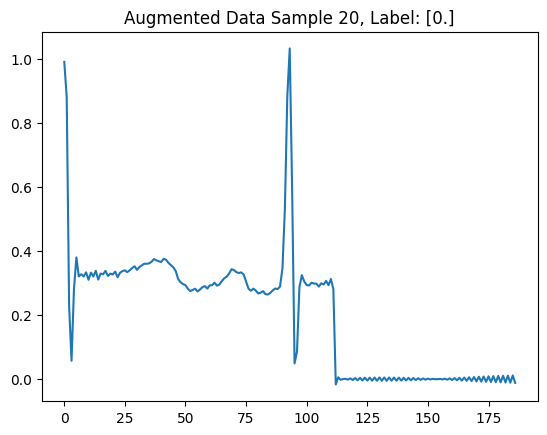

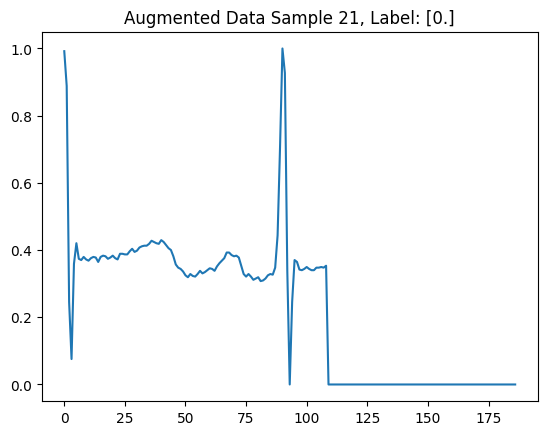

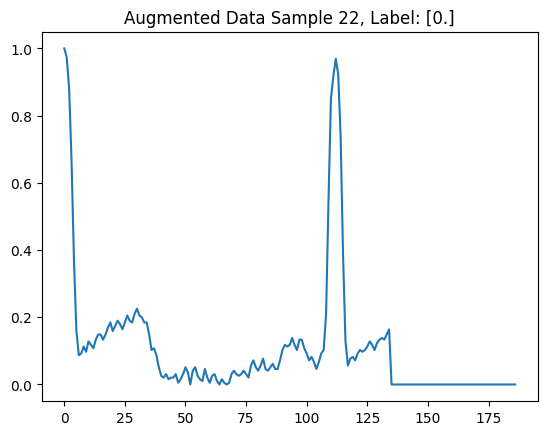

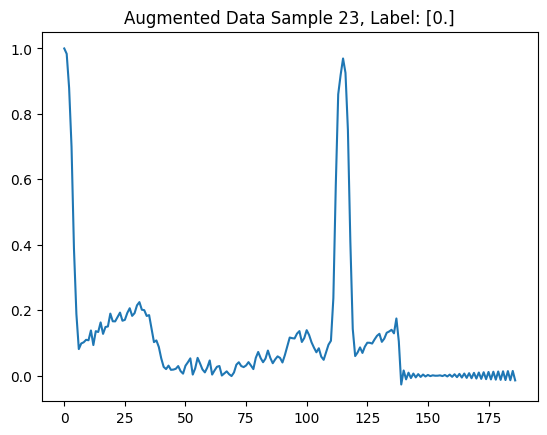

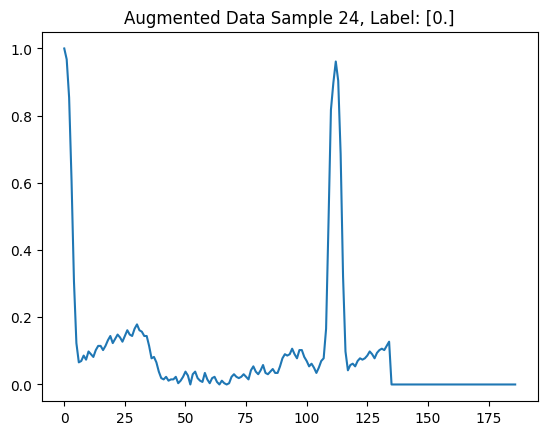

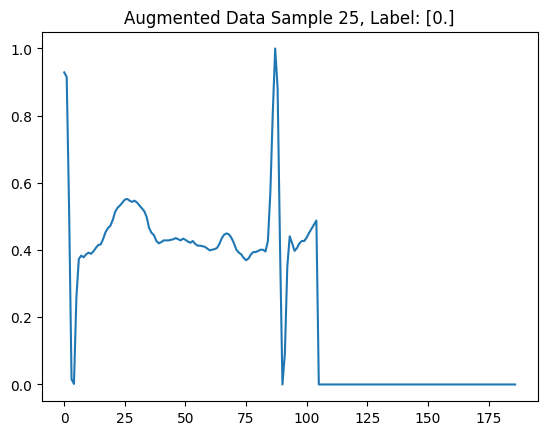

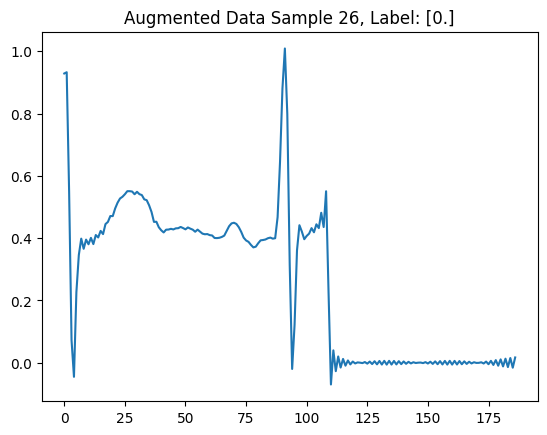

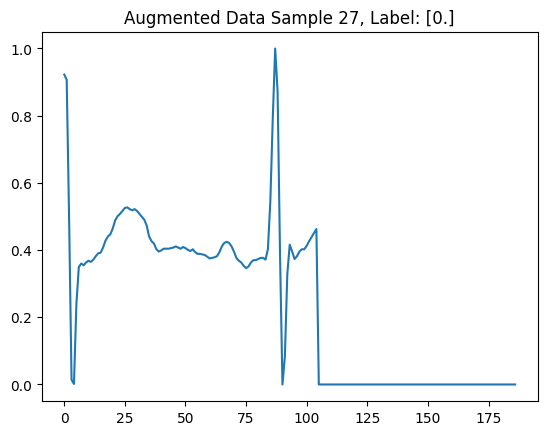

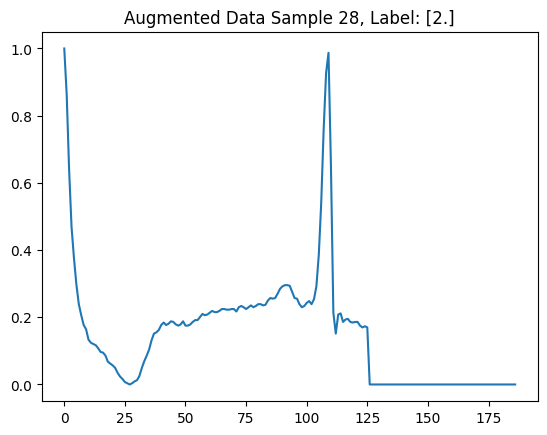

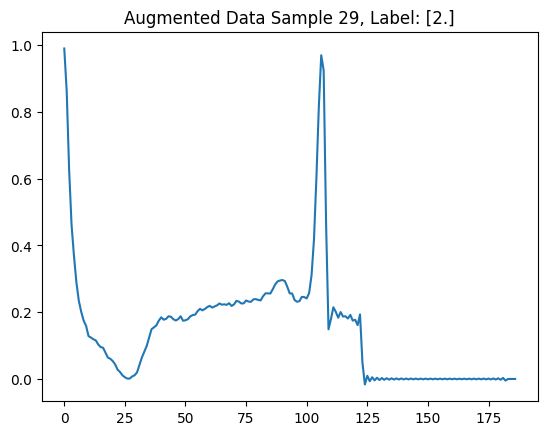

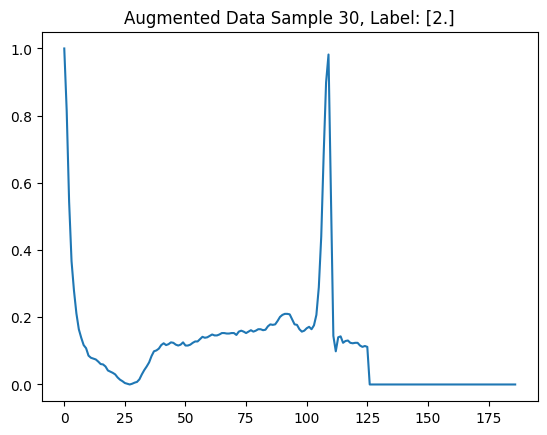

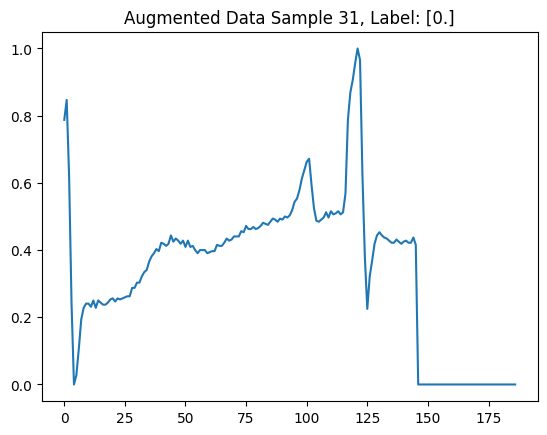

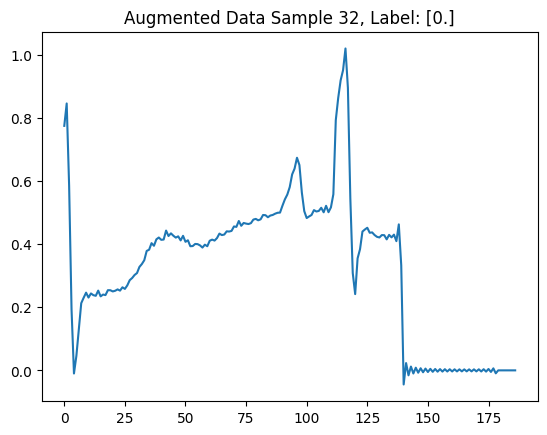

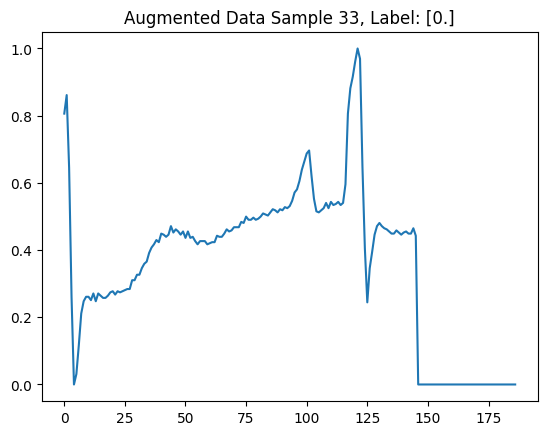

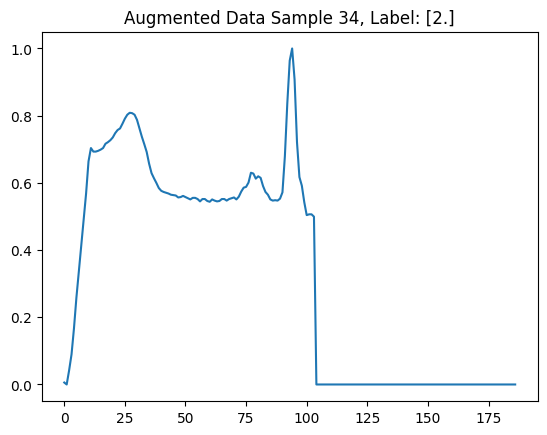

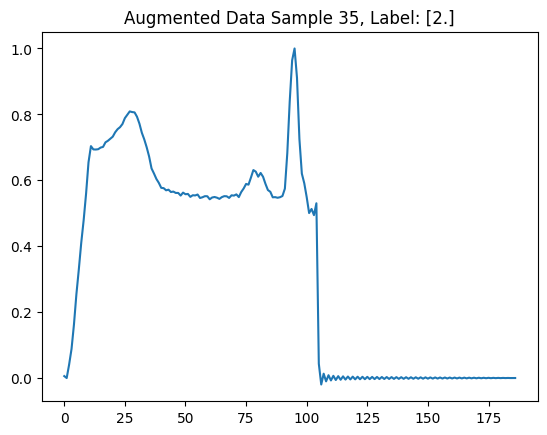

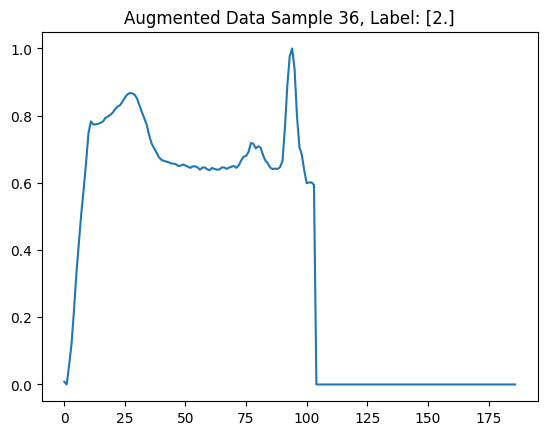

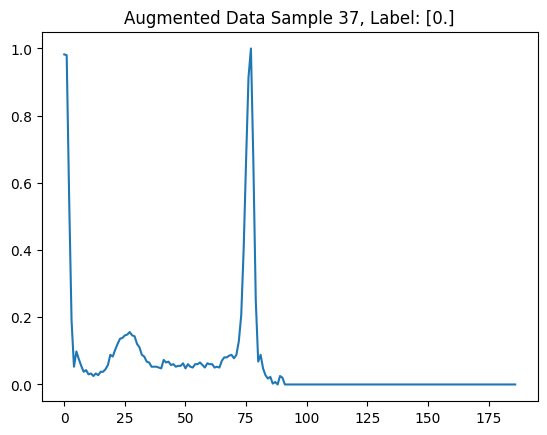

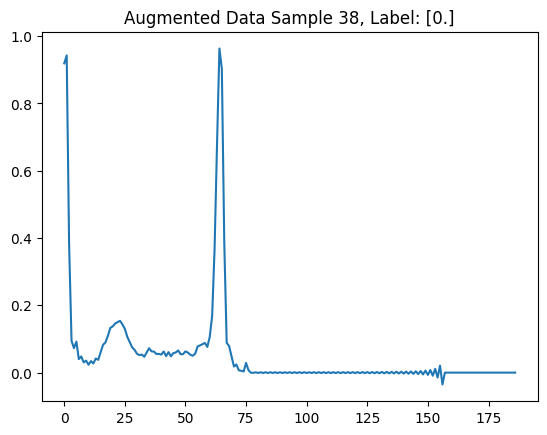

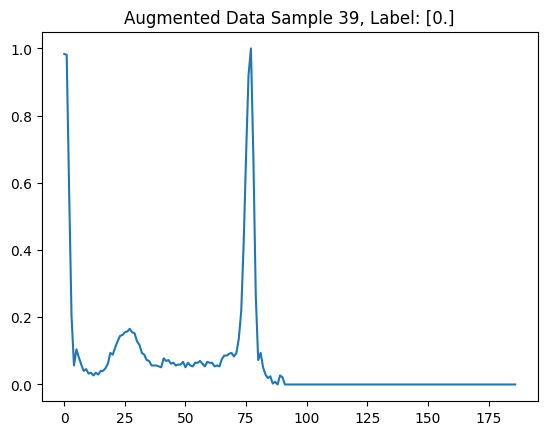

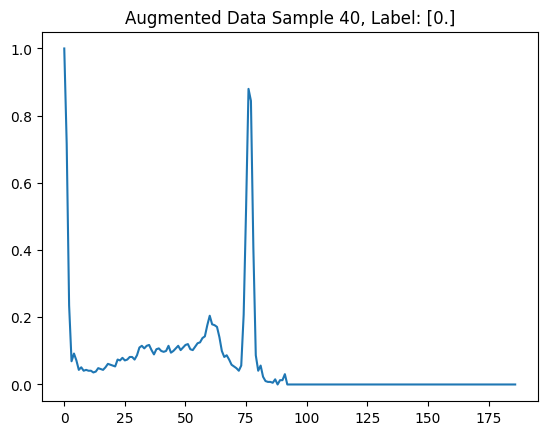

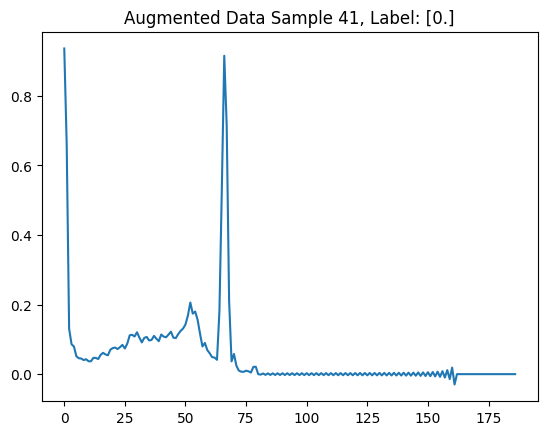

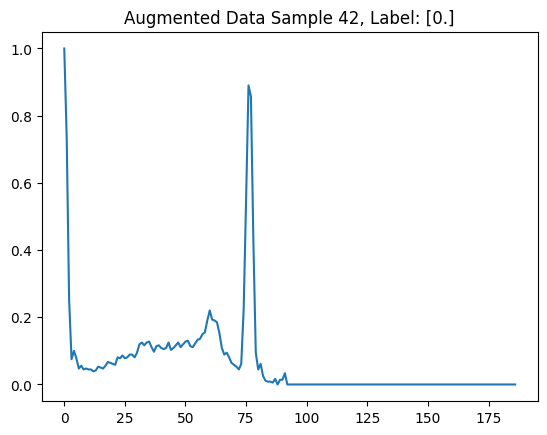

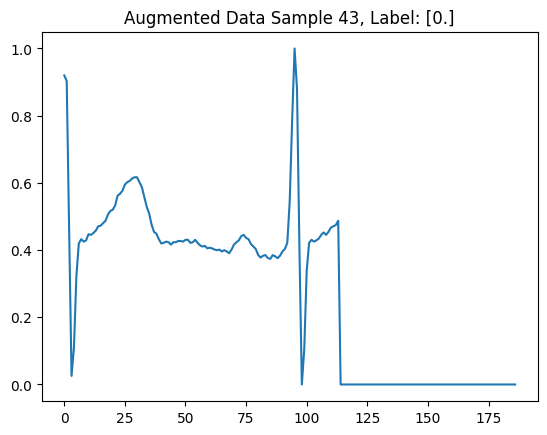

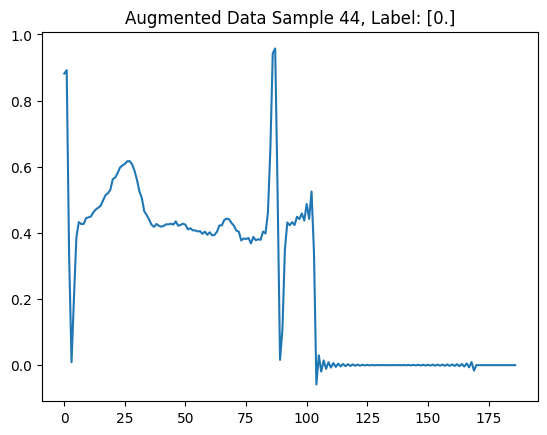

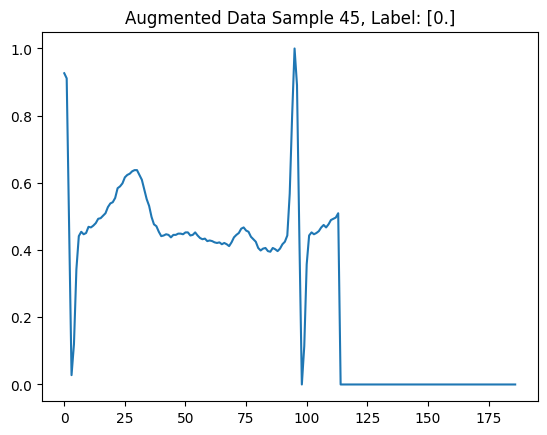

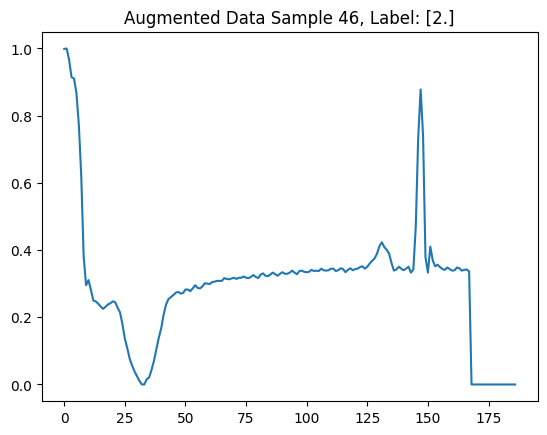

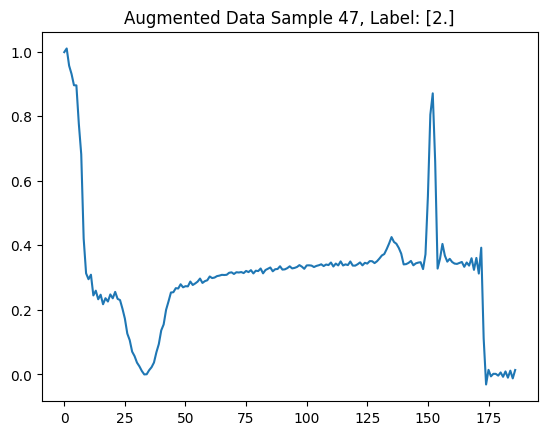

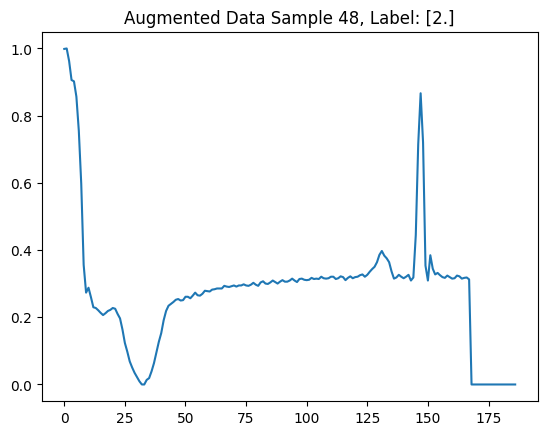

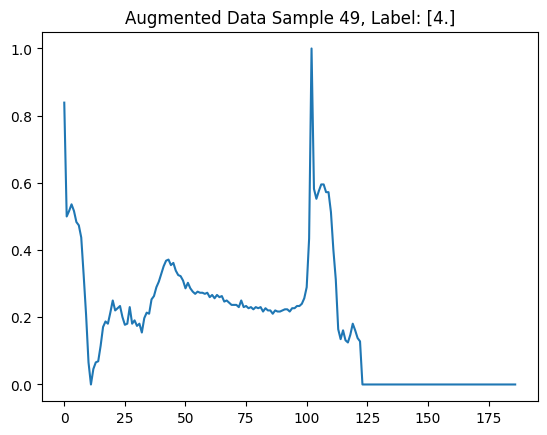

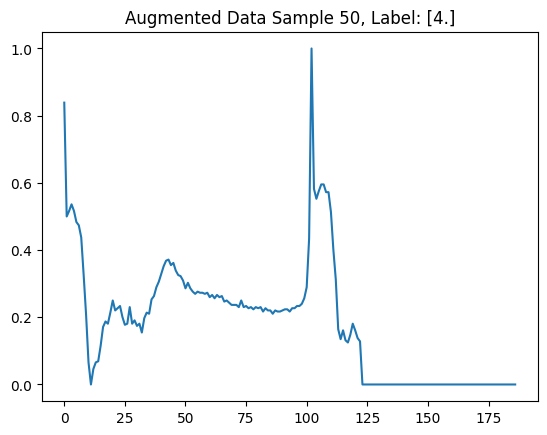

In [ ]:
# for i in range(20): 
#     plt.plot(augmented_data[i])
#     plt.title(f"Augmented Data Sample {i+1}, Label: {extended_y_train[i]}")
#     plt.show()

In [ ]:
print("Original data shape:", X_train.shape)
print("X_train shape after signal transformation:", X_train_st.shape)
print("y_train shape after signal transformation: ", y_train_st.shape)

Original data shape: (87554, 187)
X_train shape after signal transformation: (262662, 187)
y_train shape after signal transformation:  (262662,)


In [29]:
unique_classes, counts = np.unique(y_train_st, return_counts=True)

# Display the result
for class_label, count in zip(unique_classes, counts):
    print(f"Class {class_label}: {count} samples")

Class 0.0: 217413 samples
Class 1.0: 6669 samples
Class 2.0: 17364 samples
Class 3.0: 1923 samples
Class 4.0: 19293 samples


## Experiments on original and augmented datasets

### Models for testing

We are using our two main models, namely CNN+GRU and Transformer+CNN for this experiment

In [34]:
from CNN_GRU_hybrid import CNN_GRU
from CNN_Transformer_hybrid import CNNTransformerHybrid

# CONSTANTS
EPOCHS = 30
LEARNING_RATE = 0.001
CRITERION = torch.nn.CrossEntropyLoss()
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')

# Dictionary to store metrics
metrics_dict = {}

#### Train and test functions

In [35]:
from common_utils import train, evaluate, train_and_evaluate

In [36]:
def store_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    '''
    Returns a dictionary of losses and accuracies
    '''
    metrics = {}

    metrics_dict['train_losses'] = train_losses
    metrics_dict['train_acc'] = train_accuracies
    metrics_dict['test_losses'] = test_losses
    metrics_dict['test_acc'] = test_accuracies

    return metrics

### Original

In [37]:
train_data = pd.read_csv("Heartbeat_Dataset/mitbih_train.csv", header=None)
test_data = pd.read_csv("Heartbeat_Dataset/mitbih_test.csv", header=None)

# Separate into features and labels
X_train = train_data.iloc[:, :-1].values  # Exclude label
y_train = train_data.iloc[:, -1].values   # Labels

X_test = train_data.iloc[:, :-1].values  # Exclude label
y_test = train_data.iloc[:, -1].values   # Labels

# We add an additional dimension to make it suitable for 1D CNN.
X_train = np.expand_dims(X_train, axis=1)  # Change axis from 2 to 1
X_test = np.expand_dims(X_test, axis=1)    # Change axis from 2 to 1

# Get dataloaders for train and test
train_loader = get_dataloader(X_train, y_train, is_train=True)
test_loader = get_dataloader(X_test, y_test, is_train=False)

#### CNN+GRU

In [38]:
cnn_gru_model = CNN_GRU()
cnn_gru_optimizer = torch.optim.Adam(cnn_gru_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(cnn_gru_optimizer, T_max=EPOCHS)

train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(cnn_gru_model, cnn_gru_optimizer, train_loader, test_loader, DEVICE, EPOCHS, scheduler=scheduler)
torch.save(cnn_gru_model.state_dict(), './model/cnn_gru_original.pth')

metrics_dict['original_cnn_gru'] = store_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

Epoch [1/30], Train Loss: 0.1872, Train Accuracy: 94.83%, Validation Loss: 0.1092, Validation Accuracy: 97.07%
Epoch [2/30], Train Loss: 0.1043, Train Accuracy: 97.17%, Validation Loss: 0.0860, Validation Accuracy: 97.64%
Epoch [3/30], Train Loss: 0.0835, Train Accuracy: 97.69%, Validation Loss: 0.0708, Validation Accuracy: 97.93%
Epoch [4/30], Train Loss: 0.0714, Train Accuracy: 98.00%, Validation Loss: 0.0667, Validation Accuracy: 98.15%
Epoch [5/30], Train Loss: 0.0623, Train Accuracy: 98.21%, Validation Loss: 0.0516, Validation Accuracy: 98.44%
Epoch [6/30], Train Loss: 0.0538, Train Accuracy: 98.42%, Validation Loss: 0.0481, Validation Accuracy: 98.52%
Epoch [7/30], Train Loss: 0.0470, Train Accuracy: 98.56%, Validation Loss: 0.0404, Validation Accuracy: 98.80%
Epoch [8/30], Train Loss: 0.0415, Train Accuracy: 98.74%, Validation Loss: 0.0310, Validation Accuracy: 99.09%
Epoch [9/30], Train Loss: 0.0366, Train Accuracy: 98.88%, Validation Loss: 0.0344, Validation Accuracy: 99.01%
E

#### CNN+Transformer

In [ ]:
cnn_trans_model = CNNTransformerHybrid(
    input_dim=187,  # Number of features per sample (input dimension)
    num_classes=5,  # Number of output classes
    num_heads=8,    # Multi-head attention heads
    num_layers=6,   # Number of Transformer layers
    d_model=128     # Dimension of transformer model
)
cnn_trans_optimizer = torch.optim.Adam(cnn_trans_model.parameters(), lr=LEARNING_RATE)

train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(cnn_trans_model, cnn_trans_optimizer, train_loader, test_loader, DEVICE, EPOCHS)

metrics_dict['original_cnn_trans'] = store_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

### SMOTE

In [ ]:
smote_data = pd.read_csv('augmented_data/smote_dataset.csv', header=None)

X_train = smote_data.iloc[:, :-1].values  # Exclude label
y_train = smote_data.iloc[:, -1].values   # Labels

# We add an additional dimension to make it suitable for 1D CNN.
X_train = np.expand_dims(X_train, axis=1)  # Change axis from 2 to 1

# Get dataloaders for train and test
train_loader = get_dataloader(X_train, y_train, is_train=True) # from above
# test_loader = get_dataloader(X_test, y_test, is_train=False) # from above

TypeError: get_dataloader() missing 1 required positional argument: 'is_train'

#### CNN+GRU

In [ ]:
cnn_gru_model = CNN_GRU()
cnn_gru_optimizer = torch.optim.Adam(cnn_gru_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(cnn_gru_optimizer, T_max=EPOCHS)

train_losses, train_accuracies, test_losses, test_accuracies= train_and_evaluate(cnn_gru_model, cnn_gru_optimizer, train_loader, test_loader, DEVICE, EPOCHS, scheduler)
torch.save(cnn_gru_model.state_dict(), './model/cnn_gru_smote.pth')

metrics_dict['smote_cnn_gru'] = store_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

#### CNN+Transformer

In [ ]:
cnn_trans_model = CNNTransformerHybrid(
    input_dim=187,  # Number of features per sample (input dimension)
    num_classes=5,  # Number of output classes
    num_heads=8,    # Multi-head attention heads
    num_layers=6,   # Number of Transformer layers
    d_model=128     # Dimension of transformer model
)
cnn_trans_optimizer = torch.optim.Adam(cnn_trans_model.parameters(), lr=LEARNING_RATE)

train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(cnn_trans_model, cnn_trans_optimizer, train_loader, test_loader, DEVICE, EPOCHS)

metrics_dict['smote_cnn_trans'] = store_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

### Signal transformations

In [ ]:
st_data = pd.read_csv('augmented_data/st_dataset.csv', headers=None)

X_train_ = st_data.iloc[:, :-1].values  # Exclude label
y_train = st_data.iloc[:, -1].values   # Labels

# We add an additional dimension to make it suitable for 1D CNN.
X_train = np.expand_dims(X_train, axis=1)  # Change axis from 2 to 1

# Get dataloaders for train and test
train_loader = get_dataloader(X_train, y_train, is_train=True) # X_train_ts and y_train_ts from above
# test_loader = get_dataloader(X_test, y_test, is_train=False) # From above

#### CNN+GRU

In [ ]:
cnn_gru_model = CNN_GRU()
cnn_gru_optimizer = torch.optim.Adam(cnn_gru_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(cnn_gru_optimizer, T_max=EPOCHS)

train_losses, train_accuracies, test_losses, test_accuracies= train_and_evaluate(cnn_gru_model, cnn_gru_optimizer, train_loader, test_loader, DEVICE, EPOCHS, scheduler=scheduler)
torch.save(cnn_gru_model.state_dict(), './model/cnn_gru_st.pth')

metrics_dict['st_cnn_gru'] = store_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

#### CNN+Transformer

In [ ]:
cnn_trans_model = CNNTransformerHybrid(
    input_dim=187,  # Number of features per sample (input dimension)
    num_classes=5,  # Number of output classes
    num_heads=8,    # Multi-head attention heads
    num_layers=6,   # Number of Transformer layers
    d_model=128     # Dimension of transformer model
)
cnn_trans_optimizer = torch.optim.Adam(cnn_trans_model.parameters(), lr=LEARNING_RATE)

train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(cnn_trans_model, cnn_trans_optimizer, train_loader, test_loader, DEVICE, EPOCHS)

metrics_dict['st_cnn_trans'] = store_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

## Results of experiments

In [ ]:
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
metrics_df

#### CNN+GRU

In [ ]:
# CNN+GRU Graphs (Loss + Accuracy side by side for each dataset)
fig, (ax1 , ax2, ax3, ax4, ax5, ax6) = plt.subplots(3, 2, figsize=(12, 6))

# Original
cnngru_ori_dict = metrics_dict['original_cnn_gru']

original_train_loss = cnngru_ori_dict['train_losses']
original_test_loss = cnngru_ori_dict['test_losses']
ax1.plot(range(len(EPOCHS)), original_train_loss, label='Training Loss')
ax1.plot(range(len(EPOCHS)), original_test_loss, label='Test Loss')
ax1.set_title('Original Loss')
ax1.legend(loc='best')

original_train_acc = cnngru_ori_dict['train_acc']
original_test_acc = cnngru_ori_dict['test_acc']
ax1.plot(range(len(EPOCHS)), original_train_acc, label='Training Accuracy')
ax1.plot(range(len(EPOCHS)), original_test_acc, label='Test Accuracy')
ax1.set_title('Original Accuracy')
ax1.legend(loc='best')

# SMOTE
cnngru_smote_dict = metrics_dict['smote_cnn_gru']

smote_train_loss = cnngru_smote_dict['train_losses']
smote_test_loss = cnngru_smote_dict['test_losses']
ax3.plot(range(len(EPOCHS)), smote_train_loss, label='Training Loss')
ax3.plot(range(len(EPOCHS)), smote_test_loss, label='Test Loss')
ax3.set_title('SMOTE Loss')
ax3.legend(loc='best')

smote_train_acc = cnngru_smote_dict['train_acc']
smote_test_acc = cnngru_smote_dict['test_acc']
ax4.plot(range(len(EPOCHS)), smote_train_acc, label='Training Accuracy')
ax4.plot(range(len(EPOCHS)), smote_test_acc, label='Test Accuracy')
ax4.set_title('SMOTE Accuracy')
ax4.legend(loc='lower right')

# Signal Transformation
cnngru_ts_dict = metrics_dict['st_cnn_gru']

ts_train_loss = cnngru_ts_dict['train_losses']
ts_test_loss = cnngru_ts_dict['test_losses']
ax5.plot(range(len(EPOCHS)), smote_train_loss, label='Training Loss')
ax5.plot(range(len(EPOCHS)), smote_test_loss, label='Test Loss')
ax5.set_title('SMOTE Loss')
ax5.legend(loc='best')

ts_train_acc = cnngru_ts_dict['train_acc']
ts_test_acc = cnngru_ts_dict['test_acc']
ax6.plot(range(len(EPOCHS)), smote_train_acc, label='Training Accuracy')
ax6.plot(range(len(EPOCHS)), smote_test_acc, label='Test Accuracy')
ax6.set_title('SMOTE Accuracy')
ax6.legend(loc='lower right')

#### CNN+Transfomer

In [ ]:
# CNN+Transfomer Graphs (Loss + Accuracy side by side for each dataset)
fig, (ax1 , ax2, ax3, ax4, ax5, ax6) = plt.subplots(3, 2, figsize=(12, 6))

# Original
cnntrans_ori_dict = metrics_dict['original_cnn_trans']

original_train_loss = cnntrans_ori_dict['train_losses']
original_test_loss = cnntrans_ori_dict['test_losses']
ax1.plot(range(len(EPOCHS)), original_train_loss, label='Training Loss')
ax1.plot(range(len(EPOCHS)), original_test_loss, label='Test Loss')
ax1.set_title('Original Loss')
ax1.legend(loc='best')

original_train_acc = cnntrans_ori_dict['train_acc']
original_test_acc = cnntrans_ori_dict['test_acc']
ax1.plot(range(len(EPOCHS)), original_train_acc, label='Training Accuracy')
ax1.plot(range(len(EPOCHS)), original_test_acc, label='Test Accuracy')
ax1.set_title('Original Accuracy')
ax1.legend(loc='lower right')

# SMOTE
cnntrans_smote_dict = metrics_dict['smote_cnn_trans']

smote_train_loss = cnntrans_smote_dict['train_losses']
smote_test_loss = cnntrans_smote_dict['test_losses']
ax3.plot(range(len(EPOCHS)), smote_train_loss, label='Training Loss')
ax3.plot(range(len(EPOCHS)), smote_test_loss, label='Test Loss')
ax3.set_title('SMOTE Loss')
ax3.legend(loc='best')

smote_train_acc = cnntrans_ori_dict['train_acc']
smote_test_acc = cnntrans_ori_dict['test_acc']
ax4.plot(range(len(EPOCHS)), smote_train_acc, label='Training Accuracy')
ax4.plot(range(len(EPOCHS)), smote_test_acc, label='Test Accuracy')
ax4.set_title('SMOTE Accuracy')
ax4.legend(loc='lower right')

# Signal Transformation
cnngru_ts_dict = metrics_dict['ts_cnn_gru']

ts_train_loss = cnngru_ts_dict['train_losses']
ts_test_loss = cnngru_ts_dict['test_losses']
ax5.plot(range(len(EPOCHS)), smote_train_loss, label='Training Loss')
ax5.plot(range(len(EPOCHS)), smote_test_loss, label='Test Loss')
ax5.set_title('SMOTE Loss')
ax5.legend(loc='best')

ts_train_acc = cnngru_ts_dict['train_acc']
ts_test_acc = cnngru_ts_dict['test_acc']
ax6.plot(range(len(EPOCHS)), smote_train_acc, label='Training Accuracy')
ax6.plot(range(len(EPOCHS)), smote_test_acc, label='Test Accuracy')
ax6.set_title('SMOTE Accuracy')
ax6.legend(loc='lower right')